In [ ]:
from torch import nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms.functional import crop
import cv2
import matplotlib.pyplot as plt
import time
import torch

In [ ]:
def crop_r(image):
    return crop(image, 4, 124, 124, 124)
    
def crop_l(image):
    return crop(image, 4, 4, 124, 124)  
    
transform_right = transforms.Compose(
    [
        transforms.Resize((256,256)),
        #transforms.RandomRotation(10),
        transforms.Lambda(crop_r),
        transforms.ToTensor(),
        transforms.Normalize((0.36, 0.36, 0.36), (0.28, 0.28, 0.28))
    ])
transform_left = transforms.Compose(
    [
        transforms.Resize((256,256)),
        #transforms.RandomRotation(10),
        transforms.Lambda(crop_l),
        transforms.ToTensor(),
        transforms.Normalize((0.36, 0.36, 0.36), (0.28, 0.28, 0.28))
    ])

In [ ]:
train_path = '/content/drive/MyDrive/Datasets/KITTI/05'
batch_size = 1

train_r = datasets.ImageFolder(train_path, transform_right)
train_l = datasets.ImageFolder(train_path, transform_left)

train_loader_r = torch.utils.data.DataLoader(train_r, batch_size)
train_loader_l = torch.utils.data.DataLoader(train_l, batch_size)


In [ ]:
weights = models.ResNet101_Weights
model = models.resnet101(weights=weights)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def rightpt(train_loader_r, min_, max_, aux_):
  for i, data in enumerate(train_loader_r):
      if i > min_:
        inputs, labels = data
        outputs = model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(model.maxpool(model.relu(model.bn1(model.conv1(inputs)))))))))
        output_.append(outputs)
        if i > max_:
          return output_


In [ ]:
def leftpt(train_loader_l, min_, max_, aux_,output_):
  for i,data in enumerate(train_loader_l):
    if i > min_:
      inputs, labels = data
      outputs = model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(model.maxpool(model.relu(model.bn1(model.conv1(inputs)))))))))
      output_[i-aux_] = torch.cat((output_[i-aux_], outputs), 1)
      if i > max_:
          return output_
           

In [ ]:
for n_it in range(1,55):
  output_ = []
  output_new = []
  try:
    if n_it == 1:
      min_ = 0
    else:
      min_ = (n_it-1)*100
    max_ = n_it*100
    aux_ = min_ +1
    output_ = rightpt(train_loader_r, min_, max_, aux_)
    output_new = leftpt(train_loader_l, min_, max_, aux_, output_)
    out_path = '/content/drive/MyDrive/Datasets/tensors_kitti_05_resnet/tensors'+str(n_it)+'.pt'
    torch.save(output_new,out_path)
  except:
    print('error')


In [ ]:
def match(cam_img, db_img, dist_limit):
    distance = torch.cdist(cam_img, db_img, p=2)
    max_dist = torch.max(distance)
    if max_dist <= dist_limit:
        return True
    
    return False

In [ ]:
def belief_generation(db, descriptor):
    belief = []
    lp = 0
    for d in db:
        bg = match(descriptor, d, 0.25)
        if bg:
            belief.append(1)
        else:
            belief = []
        if len(belief) >= 3:
            print('loop')
            print(d)
            lp += 1
    return lp

In [ ]:
database = [database1,database2,database3,database4,database5,database6,database7,database8,database9,database10,
            database11,database12,database13,database14,database15,database16,database17,database18,database19,database20,
            database21,database22,database23,database24,database25,database26,database27,database28,database29,database30,
            database31,database32,database33,database34,database35,database36,database37,database38,database39,database40,
            database41,database42,database43,database44,database45,database46,database47,database48,database49,database50,
            database51,database52,database53,database54]
d = []

In [ ]:
co = 0
for bg in database:
  co += 1
  for i,data in enumerate(bg):
    if i < 3:
      d.append(data)
    else:
      loop_ = belief_generation(d, data)
      if loop_ > 0:
        with open('/content/drive/MyDrive/Datasets/KITTI/loop_kitti_05_resnet_v2.txt', 'a') as txt_file:
          txt_file.write('\n Found loop')
          image_number = round(((co*100)+i)/2,0)
          txt_file.write('\n image: '+str(image_number))
      else:
        d.append(data)
  



A saída de streaming foi truncada nas últimas 5000 linhas.

         [[0.3793]]]], requires_grad=True)
loop
tensor([[[[0.5845]],

         [[0.4835]],

         [[0.7445]],

         ...,

         [[0.5125]],

         [[0.4881]],

         [[0.3965]]]], requires_grad=True)
loop
tensor([[[[0.6103]],

         [[0.4917]],

         [[0.7714]],

         ...,

         [[0.5221]],

         [[0.4862]],

         [[0.4002]]]], requires_grad=True)
loop
tensor([[[[0.5983]],

         [[0.4217]],

         [[0.7680]],

         ...,

         [[0.4856]],

         [[0.5350]],

         [[0.3639]]]], requires_grad=True)
loop
tensor([[[[0.5876]],

         [[0.4380]],

         [[0.7699]],

         ...,

         [[0.4904]],

         [[0.5060]],

         [[0.3783]]]], requires_grad=True)
loop
tensor([[[[0.6103]],

         [[0.4917]],

         [[0.7714]],

         ...,

         [[0.5221]],

         [[0.4862]],

         [[0.4002]]]], requires_grad=True)
loop
tensor([[[[0.6136]],

     

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Datasets/metricas/kitti_05_resnet_v2.csv')


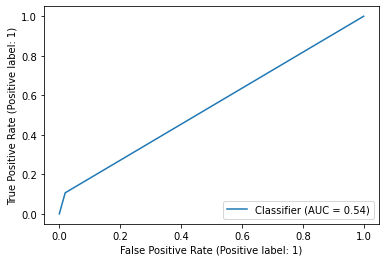

In [ ]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt


RocCurveDisplay.from_predictions(df['actual'], df['pred'])
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


print('AUC: ',roc_auc_score(df['actual'], df['pred']))
print('Accuracy: ',accuracy_score(df['actual'], df['pred']))
print('f1: ',f1_score(df['actual'], df['pred']))


AUC:  0.5437177434360646
Accuracy:  0.8739587106120971
f1:  0.17142857142857143


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(df['actual'], df['pred'])

array([[2377,   47],
       [ 301,   36]])